In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.io import wavfile
import os
import numpy as np
import pandas as pd
from scipy.fft import fft # fast fourier transform
""" The objective of this copy is to slice up the audio sample,
    do separate FFTs and find the FF of each chunk.
    This differs from the spectrogram in the sense that everything is
    given in terms of multiples of the FF."""

' The objective of this copy is to slice up the audio sample,\n    do separate FFTs and find the FF of each chunk.\n    This differs from the spectrogram in the sense that everything is\n    given in terms of multiples of the FF.'

IMPORTING FILE

Audio data shape is
(141120, 2)


Text(0.5, 1.0, 'Audio signal in time')

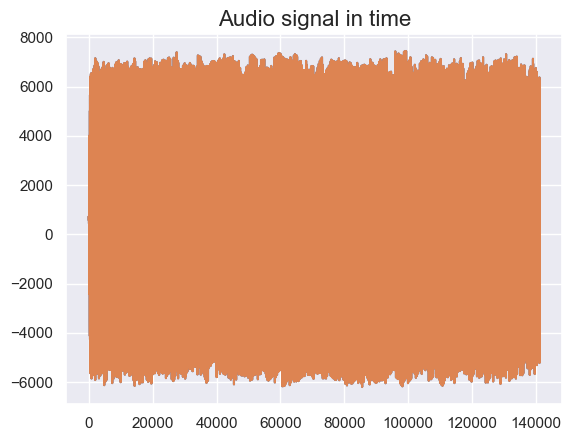

In [16]:
""" Note: Each sample in my set releases the note halfway.
False -> we train with the release behavior (not a good idea).
True -> we don't, and we only use the first half of each sample.
"""
dont_use_release = True

SampleName = "01 - [Prologue]_1.wav" # Audio File
os.chdir('./data/wav/')
SampleRate, Audiodata = wavfile.read(SampleName)

if dont_use_release:
    Audiodata = Audiodata[0:len(Audiodata)//2,:]

print('Audio data shape is') #Old shape was (35280,2)
print(np.shape(Audiodata))

# Plot the audio signal in time
plt.plot(Audiodata)
plt.title('Audio signal in time',size=16)

FAST FOURIER TRANSFORM \& SPECTRUM

FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
FFT of audio data shape is
(8192,)
           0           1           2           3          4          5   \
0  357.933605  418.790875  206.613102  311.973784  75.875235  89.878358   
1  293.956693  348.565308  168.422898  264.057877  61.295330  74.155500   
2  152.452520  192.293027   84.646554  156.160283  29.479483  40.729587   
3   32.554257   56.251945   15.828248   59.260669   4.896166  16.510478   
4   11.828950    4.980282   10.488318   20.312126   8.806672   8.

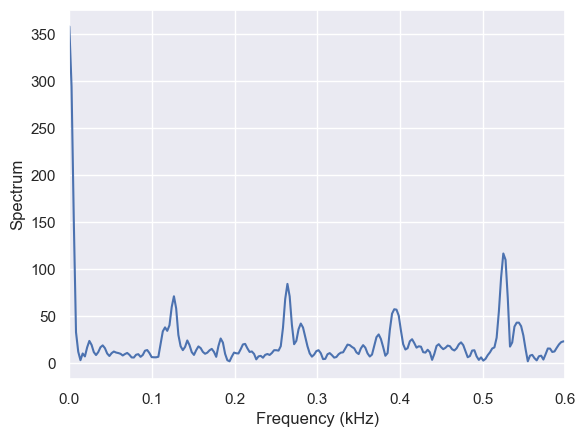

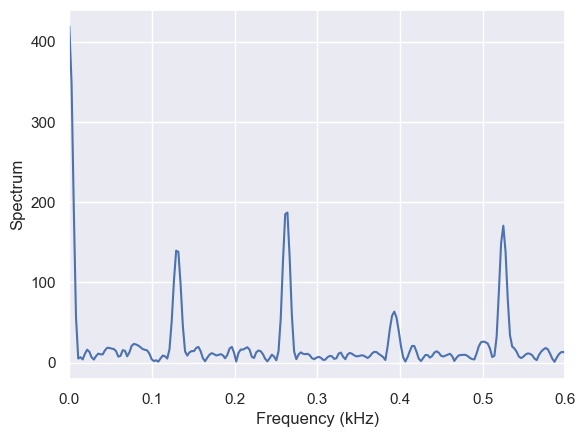

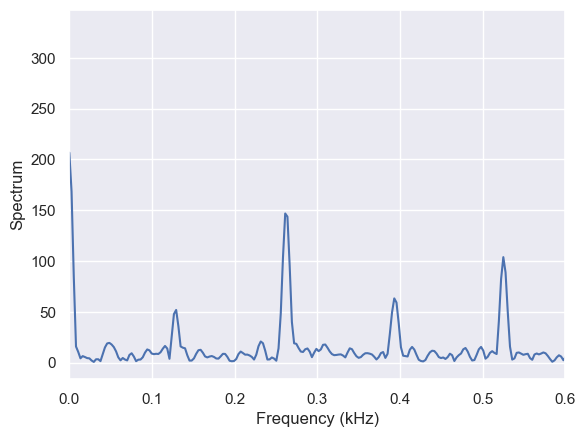

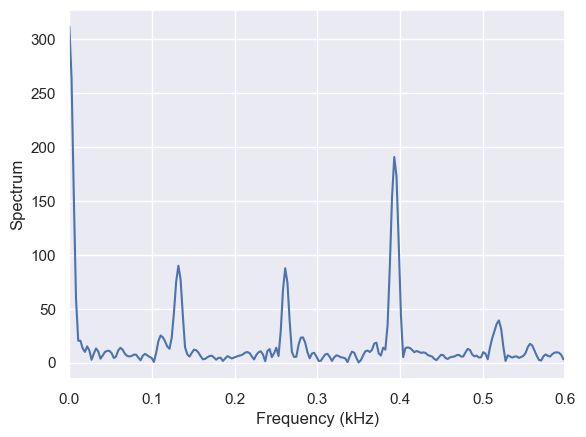

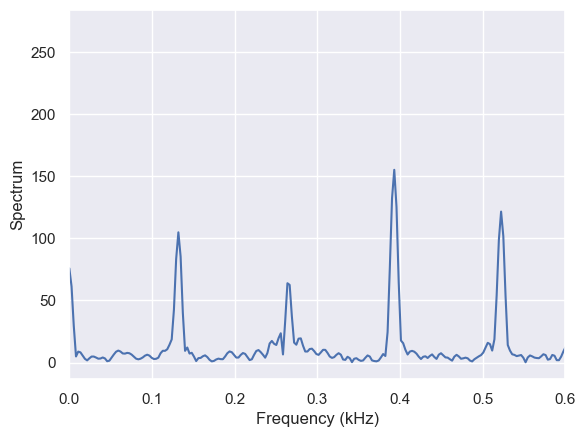

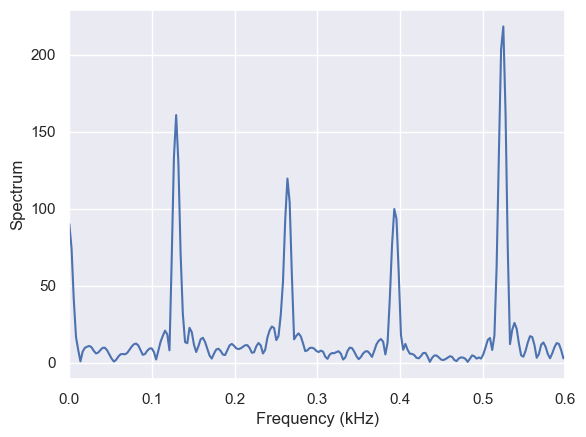

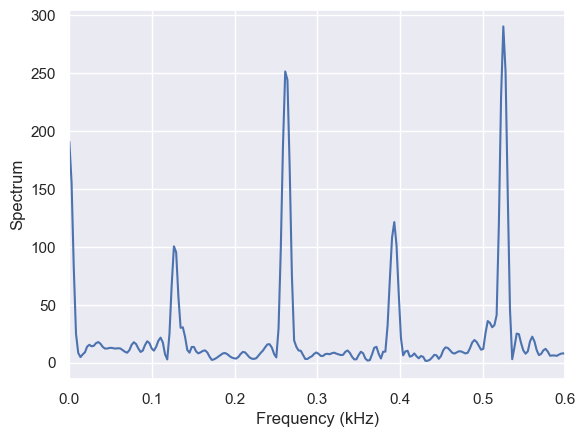

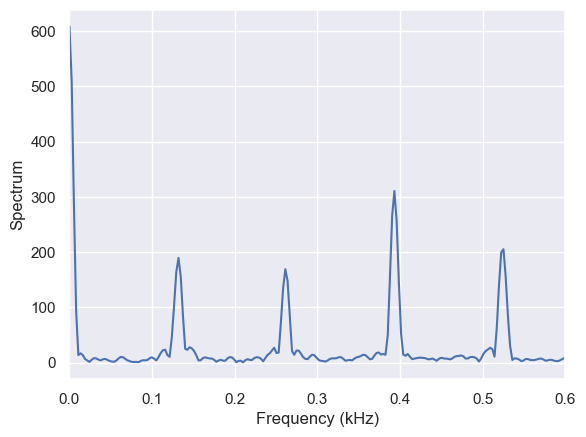

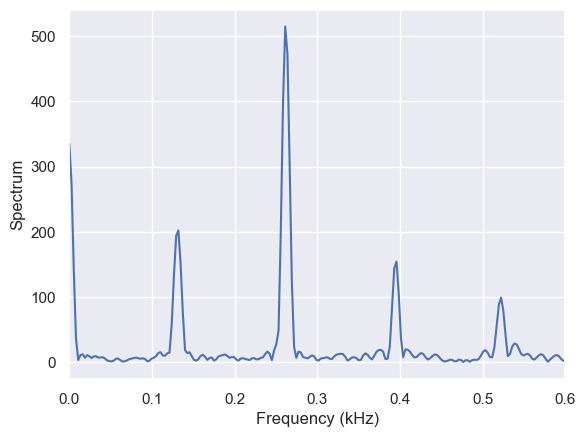

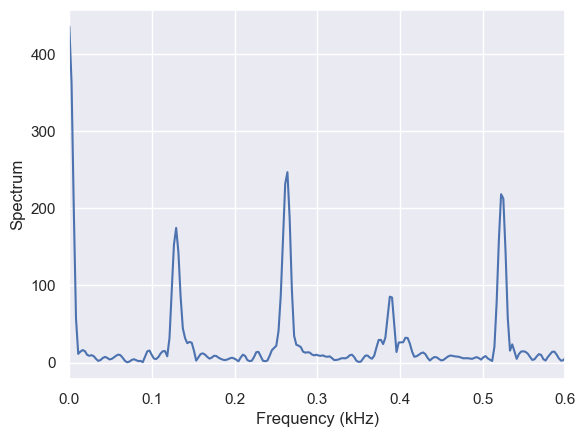

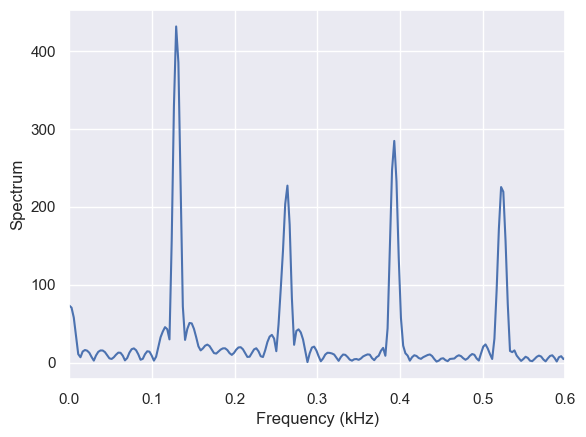

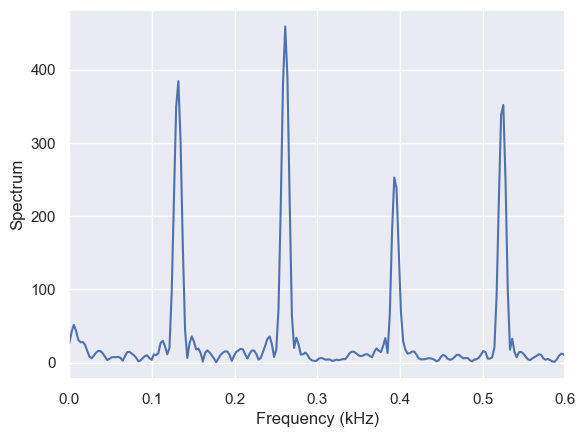

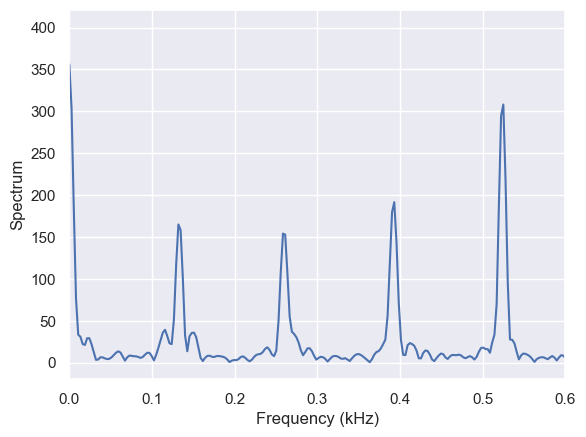

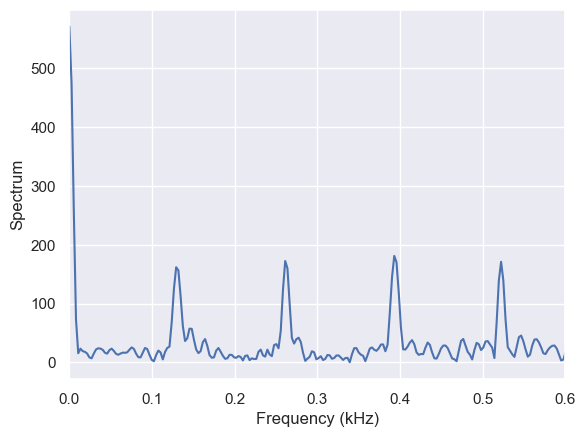

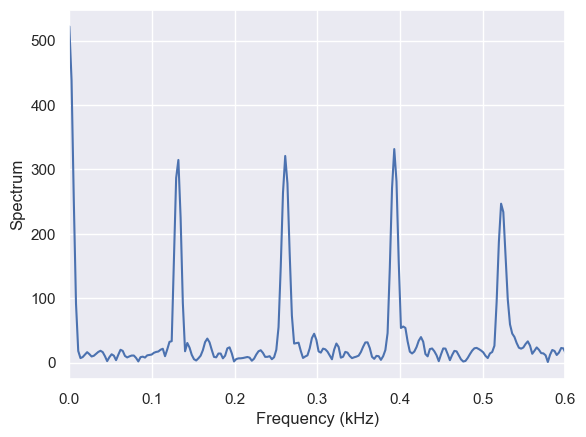

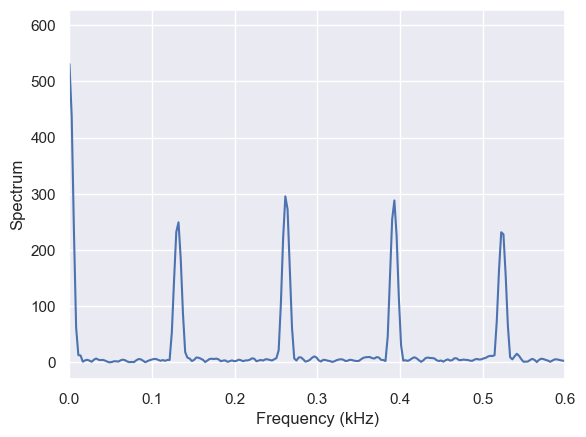

In [36]:
num_pieces = 16 # Each sample is 3.2 seconds without release tail, 6.4 seconds with it.
m = len(Audiodata)
piece_size = int(m / num_pieces)

FFTSize = 16384 # have to use a multiple of 2 for optimal speed. Old was 8192
Freq_series = pd.DataFrame()

for i in np.arange(0, num_pieces):
    AudioFreq = fft(Audiodata[i*piece_size:(i+1)*piece_size,1]*np.hanning(np.shape(Audiodata)[0]/num_pieces),n=FFTSize,axis=0) #with a Hanning window
    AudioFreq = AudioFreq[0:int(np.ceil((np.shape(AudioFreq)[0])/2.0))] #Left half of the spectrum
    MagFreq = np.abs(AudioFreq) # Magnitude
    MagFreq = MagFreq / float(piece_size)
    print('FFT of audio data shape is') # Old shape was (4096,)
    print(np.shape(MagFreq))
    plt.figure()
    freqAxis = np.arange(0,int(np.ceil((piece_size+1)/2.0)), int(np.ceil((piece_size+1)/2.0))*2/FFTSize) * (SampleRate / piece_size);
    plt.plot(freqAxis/1000.0, MagFreq) #Spectrum
    plt.xlabel('Frequency (kHz)'); plt.ylabel('Spectrum');
    plt.xlim([0, 0.6])
    Freq_series[i] = MagFreq

print(Freq_series.head())

FINDING THE FUNDAMENTAL FREQUENCY, ASSESSING ACCURACY OF THE FF, \& MEASURING SPIKES

In [40]:
# HPS (Harmonic Product Spectrum) Algorithm to determine fundamental frequency

k = len(MagFreq)
HPSSizeFloat = k/3.0
HPSSize = int(np.ceil(k)/3.0 + 1)

for i in np.arange(0, num_pieces):
    MagFreq2 = np.array(Freq_series[i]).reshape(int(np.ceil(k)/2.0),2).mean(1)[0:HPSSize]
    MagFreq3 = np.concatenate([np.array(Freq_series[i]),np.zeros(3 - int(k) % 3)]).reshape(int(np.ceil(k)/3.0 + 1),3).mean(1)[0:HPSSize]
    print(np.shape(MagFreq2))
    print(np.shape(MagFreq3))
    HPS = np.array(Freq_series[i])[0:HPSSize]*MagFreq2*MagFreq3
    freqAxisDownscaled = np.arange(0,int(np.ceil((m+1)/2.0)), int(np.ceil((m+1)/2.0))*6/FFTSize) * (SampleRate / m);
    FFLocHPS = np.argmax(HPS[freqAxisDownscaled >= 50]) + int(len(HPS[freqAxisDownscaled < 50])) # don't look below 50 Hz for it, due to noise.
    FFLocation = (FFLocHPS-1)*3 # FFLocHPS uses an index that is scaled down by 1/3. Have to reverse that.
    print('Fundamental frequency\'s location is at index... ',FFLocation)
    print('Fundamental frequency is...',freqAxis[FFLocation],'Hz.')
    # Have to ensure the fundamental frequency is accurate. Take loudest spike, get its approximate ratio, round to nearest int.
    MaxLoc = np.argmax(MagFreq[freqAxis >= 50]) + int(len(MagFreq[freqAxis < 50])) # don't look below 50 Hz for it, due to noise.
    MaxRatio = np.max([np.round(freqAxis[MaxLoc]/freqAxis[FFLocation]), 1])
    print('The loudest ratio is ',MaxRatio)
    FFreq = freqAxis[MaxLoc]/MaxRatio
    print('Corrected fundamental frequency is ',FFreq,' Hz.')
    MagFreqLog = 10*np.log10(MagFreq)
    FFreqLoc = np.argmin(np.abs(freqAxis - FFreq))
    print('Closest match found at index ',FFreqLoc)
    # If the frequency immediately on either side of each "spike" is louder, make that the new spike.
    FFreqLoc = FFreqLoc - ((MagFreqLog <= np.roll(MagFreqLog,1)) & (np.roll(MagFreqLog,-1) <= np.roll(MagFreqLog,1))) #if the left entry is >= the entry and the right entry, then make the left entry the new spike location
    FFreqLoc = FFreqLoc + ((MagFreqLog <= np.roll(MagFreqLog,-1)) & (np.roll(MagFreqLog,1) <= np.roll(MagFreqLog,-1)))  #if the right entry is >= the entry and the left entry, then make the right entry the new spike location
    numberSpikes = 20
    Multiples = [FFreq*i for i in np.arange(0,numberSpikes)]
    Multiples[0] = FFreq/2 # It turns out, telling the YM2612 to use the "0th" multiple means 1/2 the FF.
    print(Multiples)
    MultiplesLoc = [np.argmin(np.abs(freqAxis - i)) for i in Multiples]
    print(MultiplesLoc)
    # Next, make an integer ratio-indexed list of the amplitudes!
    MultiplesMag = MagFreq[MultiplesLoc]
    print(MultiplesMag)
    MultiplesdB = MagFreqLog[MultiplesLoc]
    print(MultiplesdB)

(2731,)
(2731,)
Fundamental frequency's location is at index...  1164
Fundamental frequency is... 3133.79150390625 Hz.
The loudest ratio is  1.0
Corrected fundamental frequency is  1572.2802734375  Hz.
Closest match found at index  584
[786.14013671875, 1572.2802734375, 3144.560546875, 4716.8408203125, 6289.12109375, 7861.4013671875, 9433.681640625, 11005.9619140625, 12578.2421875, 14150.5224609375, 15722.802734375, 17295.0830078125, 18867.36328125, 20439.6435546875, 22011.923828125, 23584.2041015625, 25156.484375, 26728.7646484375, 28301.044921875, 29873.3251953125]
[292, 584, 1168, 1752, 2336, 2920, 3504, 4088, 4672, 5256, 5840, 6424, 7008, 7592, 8176, 8191, 8191, 8191, 8191, 8191]
[334.02544335 597.8235443   86.95128255  25.82591436   4.16465112
   7.67170149   6.55442855   4.84327071   3.86916782   6.41662906
   3.49318094   3.32452522   8.32593211   2.57327097   2.37976999
   1.58858759   1.58858759   1.58858759   1.58858759   1.58858759]
[25.23779549 27.76573015 19.39275992 14.12